In [1]:
!pip install dowhy

In [2]:
import time
from itertools import combinations
from tqdm import tqdm

import numpy as np
import pandas as pd
import networkx as nx
import pingouin as pg
from dowhy import CausalModel
import matplotlib.pyplot as plt

np.random.seed(0)

# Поиск причинно-следственной структуры в данных

Сегодня мы поговорим о том, как использовать библиотеку causal-learn для поиска причинно-следственной структуры в данных.

Перед тем как начать работу с алгоритмами causal discovery, предлагается изучить используемые данные. Датасет **LUCAS** (*LUng CAncer Simple set*) содержат 11 бинарных переменных, значения которых были сгенерированы относительно следующей причинно-следственной байесовской сети:

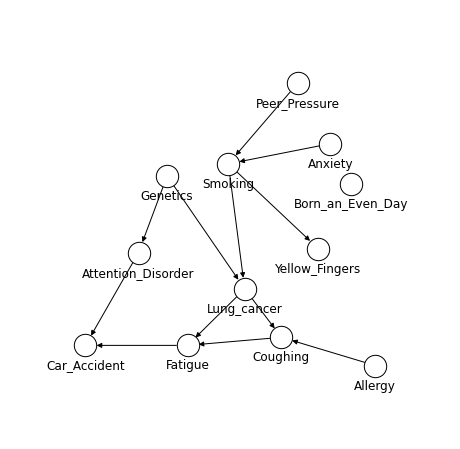

In [3]:
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

# визуализация
def draw_graph(G, pos):
    colors = ['red' if (y,x) in G.edges() else 'black' for (x,y) in G.edges()]

    pos_nodes = nudge(pos, 0.0, -0.5)

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.margins(0.2)
    nx.draw(G, ax=ax, pos=pos, with_labels=False, node_size=500, node_color='w', edgecolors='black', edge_color=colors)
    nx.draw_networkx_labels(G, ax=ax, pos=pos_nodes, font_size=12)
    
df = pd.read_csv('lucas0_train.csv')

nodes = list(df.columns)

true_graph = nx.DiGraph()
true_graph.add_nodes_from(nodes)
true_graph.add_edges_from([('Smoking', 'Lung_cancer'),
                           ('Smoking', 'Yellow_Fingers'),
                           ('Anxiety', 'Smoking'),
                           ('Peer_Pressure', 'Smoking'),
                           ('Genetics', 'Lung_cancer'),
                           ('Lung_cancer', 'Coughing'),
                           ('Lung_cancer', 'Fatigue'),
                           ('Genetics', 'Attention_Disorder'),
                           ('Allergy', 'Coughing'),
                           ('Coughing', 'Fatigue'),
                           ('Fatigue', 'Car_Accident'),
                           ('Attention_Disorder', 'Car_Accident'),])

# укладка графа
pos = {'Smoking':(4,5), 'Yellow_Fingers':(6.2,2.9), 'Anxiety':(6.5, 5.5), 'Peer_Pressure':(5.7, 7), 'Genetics':(2.5, 4.7), 'Attention_Disorder':(1.8,2.8),
       'Born_an_Even_Day':(7, 4.5), 'Car_Accident':(0.5,0.5), 'Fatigue':(3, 0.5), 'Allergy':(7.6,0.), 'Coughing':(5.3, 0.7), 'Lung_cancer':(4.4,1.9)}

draw_graph(true_graph, pos)

In [4]:
df.head()

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1


Граф задан относительно следующих условных и безусловных вероятностей:

$$
\begin{equation*}
\begin{aligned}

P(Anxiety=T)=0.642 \\
P(Peer \; Pressure=T)=0.329 \\
P(Smoking=T|Peer \; Pressure=F, Anxiety=F)=0.431 \\
P(Smoking=T|Peer \; Pressure=T, Anxiety=F)=0.745 \\
P(Smoking=T|Peer \; Pressure=F, Anxiety=T)=0.868 \\
P(Smoking=T|Peer \; Pressure=T, Anxiety=T)=0.915 \\
P(Yellow \; Fingers=T|Smoking=F)=0.231 \\
P(Yellow \; Fingers=T|Smoking=T)=0.953 \\


\end{aligned}
\qquad
\begin{aligned}

P(Fatigue=T|Lung \; cancer=F, Coughing=F)=0.352 \\
P(Fatigue=T|Lung \; cancer=T, Coughing=F)=0.565 \\
P(Fatigue=T|Lung \; cancer=F, Coughing=T)=0.801 \\
P(Fatigue=T|Lung \; cancer=T, Coughing=T)=0.895 \\
P(Car \; Accident=T|Attention \; Disorder=F, Fatigue=F)=0.227 \\
P(Car \; Accident=T|Attention \; Disorder=T, Fatigue=F)=0.779 \\
P(Car \; Accident=T|Attention \; Disorder=F, Fatigue=T)=0.788 \\
P(Car \; Accident=T|Attention \; Disorder=T, Fatigue=T)=0.971 \\

\end{aligned}

\end{equation*}
$$

$$
\begin{equation*}
\begin{aligned}

P(Genetics=T)=0.159 \\
P(Lung \; cancer=T|Genetics=F, Smoking=F)=0.231 \\
P(Lung \; cancer=T|Genetics=T, Smoking=F)=0.869 \\
P(Lung \; cancer=T|Genetics=F, Smoking=T)=0.839 \\
P(Lung \; cancer=T|Genetics=T, Smoking=T)=0.993 \\
P(Attention \; Disorder=T|Genetics=F)=0.289 \\
P(Attention \; Disorder=T|Genetics=T)=0.687 \\

\end{aligned}
\qquad
\begin{aligned}

P(Born \; an \; Even \; Day=T)=0.5 \\
P(Allergy=T)=0.328 \\
P(Coughing=T|Allergy=F, Lung \; cancer=F)=0.134 \\
P(Coughing=T|Allergy=T, Lung \; cancer=F)=0.645 \\
P(Coughing=T|Allergy=F, Lung \; cancer=T)=0.766 \\
P(Coughing=T|Allergy=T, Lung \; cancer=T)=0.999 \\

\end{aligned}

\end{equation*}
$$

Можно заметить, что среди переменных, относящихся непосредственно к здоровью человека, присутствует $Born \; an \; Even \; Day$ - мы ожидаем, что используемые в дальнейшем алгоритмы не будут учитывать ее в восстановленном по данным причинно-следственно графе (т. е. ей будет соответствовать изолированная вершина).

# Constraint-based алгоритмы

**Алгорим Петера-Кларка** (также известный как **PC**; назван в честь его авторов - Петера Спиртеса и Кларка Глимура) является constraint-based алгоритмом, основанном на итеративном применении тестов на условную незаивисимость к данным. Прежде чем перейти к непосредственно к нему, мы посмотрим на его упрощенную версию, а именно на алгоритм [SGS](https://www.researchgate.net/publication/242448131_Causation_Prediction_and_Search) - он имеет тот же формат входных / выходных данных и поэтому перейти от него к PC будет вполне естественно. 

Оба алгоритма имеют следующие допущения:
- faithfulness - все условные независимости в данных влекут за собой d-separation в причинно-следственном графе;
- causal sufficiency - отсутствие скрытых конфаундеров, отсутствие selection bias;
- acyclicity - отсутствие циклов в конечном графе.

Этапы работы алгоритмов:
- Вычисление скелета;
- Вычисление v-структуры;
- Ориентация ребер.

## SGS 

### Шаг 1: Вычисление скелета графа

Сгенерируем полносвязный граф $G = (V, E)$ относительно имеющихся переменных:

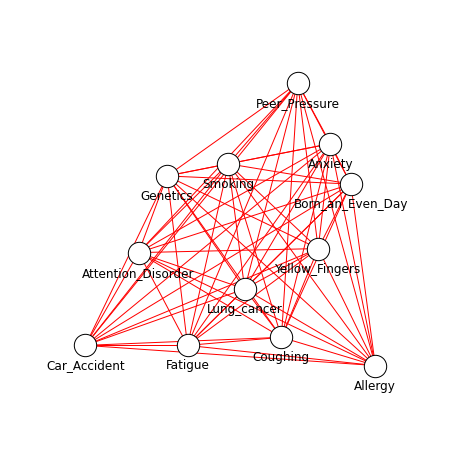

In [4]:
nodes = list(df.columns)

# стартовый полносвязный граф
skeleton = nx.Graph()
skeleton.add_nodes_from(nodes)
skeleton.add_edges_from(combinations(nodes, 2))

draw_graph(skeleton, pos)

Последовательно приемним тесты на условную независимость относительно каждой пары вершин $(i, j) \in G$ и всех подмножеств $S \subseteq V \backslash \{i, j\} $ оставшихся вершин графа.

In [5]:
def skeleton_learning(df, skeleton, alpha=0.05, verbose=False):

    time_ = []

    # размер множества для проверки условной независимости
    for k in range(len(skeleton.nodes())-1):
        start = time.time()
        # перебираем все пары вершин
        for (x, y) in combinations(skeleton.nodes(), 2):
            # для каждого подмножества S из |V|\{x,y} такого что |S| = k 
            for s in combinations(set(skeleton.nodes()).difference([x,y]), k):
                # проверяем нулевую гипотезу об условной независимости x и y по s
                p_val = pg.partial_corr(data=df, x=x, y=y, covar=list(s)).round(3)['p-val'].item()
                # если нам не удается отвергунть нулевую гипотезу, то x и y не могут быть смежными
                if p_val > alpha and skeleton.has_edge(x, y):
                    if verbose == True:
                        print("removing edge: ", (x, y))
                    skeleton.remove_edge(x, y)
        end = time.time()
        time_.append(end - start)

        draw_graph(skeleton, pos)
        plt.text(0.2, 7, 'k='+str(k), fontsize=34)
        plt.text(0.2, 6.4, 'time: ' + str(round(time_[-1], 2)), fontsize=24)
#        plt.savefig('SGS_stage_1n/' + str(k) + '.png')


    return skeleton, time_

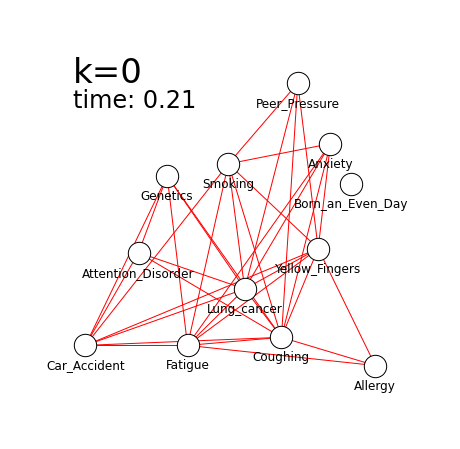

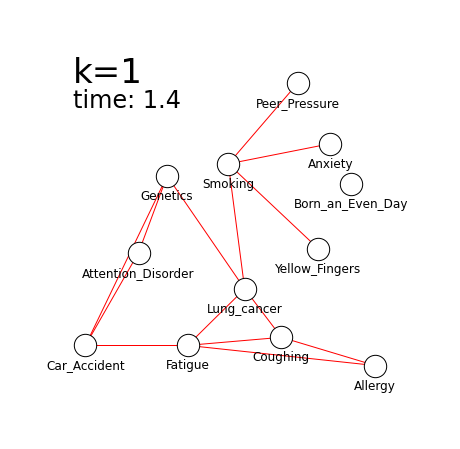

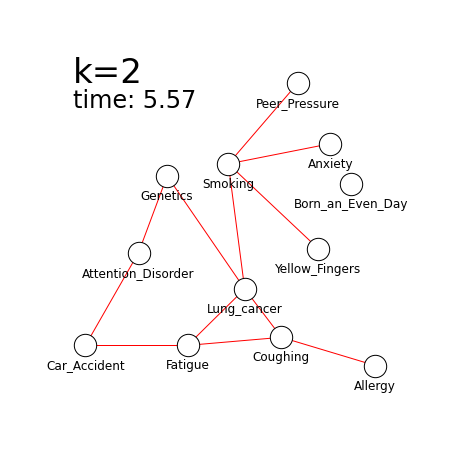

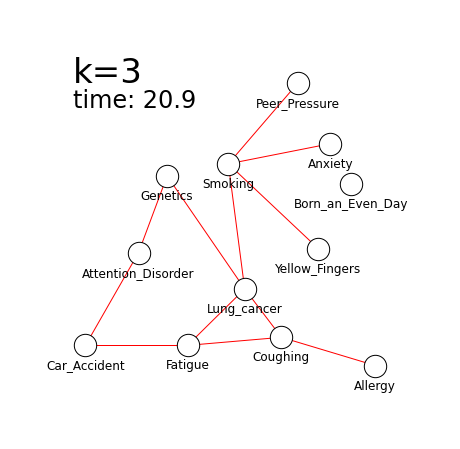

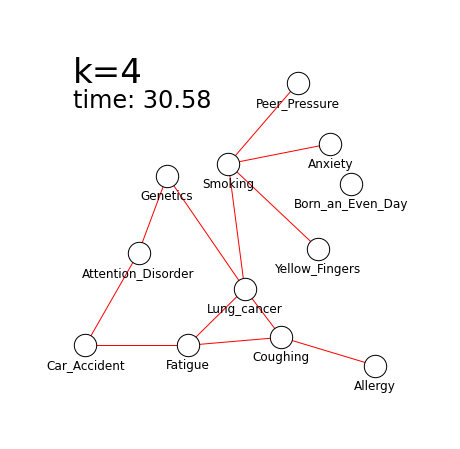

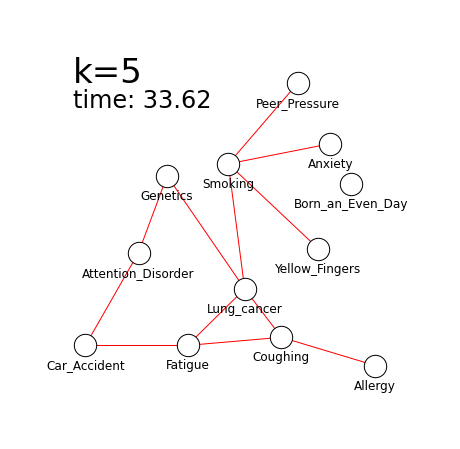

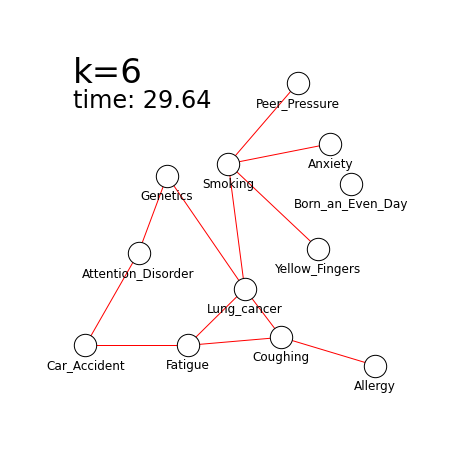

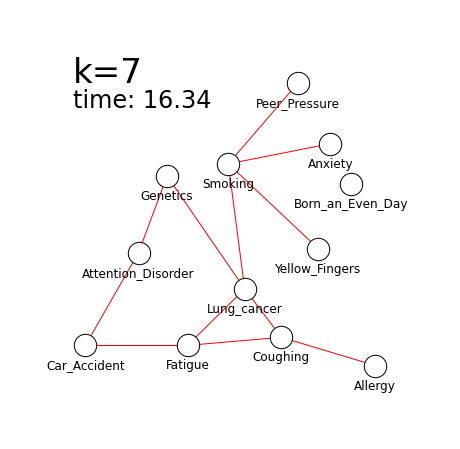

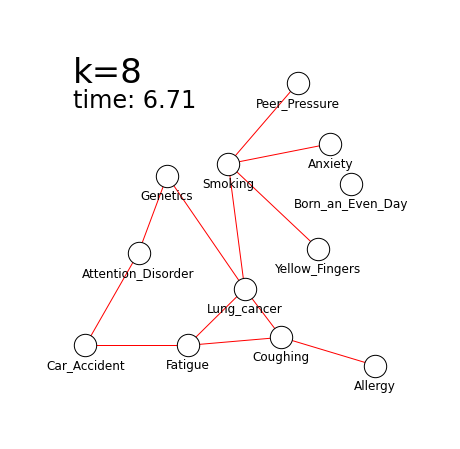

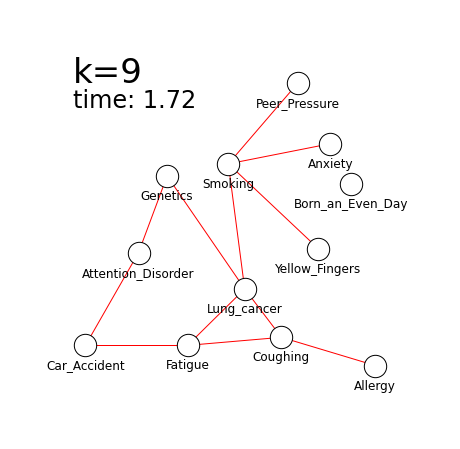

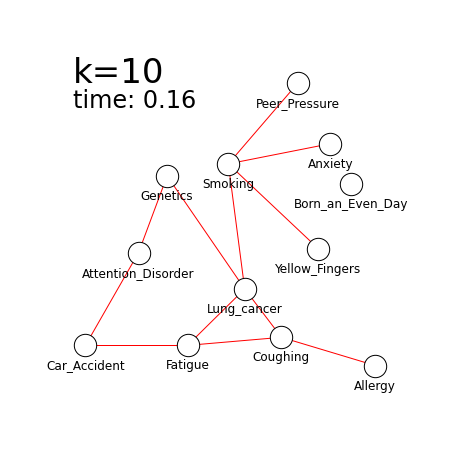

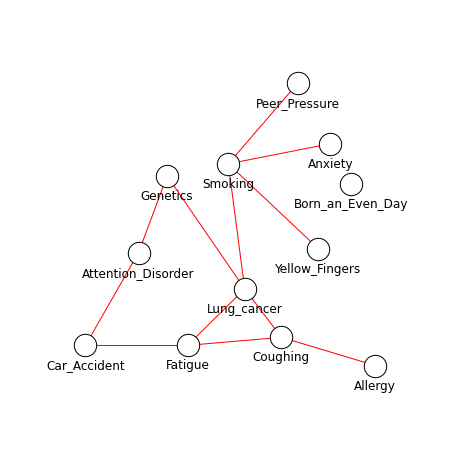

In [6]:
# используемый в тесте уровень значимости
alpha = 0.05

skeleton, t = skeleton_learning(df, skeleton)
draw_graph(skeleton, pos)

Давайте посмотрим на распределение затраченного на различные этапы времени:

Text(0, 0.5, 'time, sec')

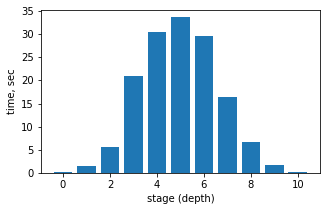

In [7]:
ks = [i for i in range(len(t))]
fig, ax = plt.subplots(1, figsize=(5, 3))
ax.bar(ks, t)
ax.set_xlabel('stage (depth)')
ax.set_ylabel('time, sec')

Как видно из графов каждого этапа, структурные изменения перестали наблюдаться после 2-го этапа (т .е. $\#\{S\} = 2$), в то время как наибольшее количество времени было потрачено на итерации 4, 5 и 6. 

Конвертируем неориентированный граф в ориентированный (*примечание: в найденном скелете все ребра двунаправленные*).

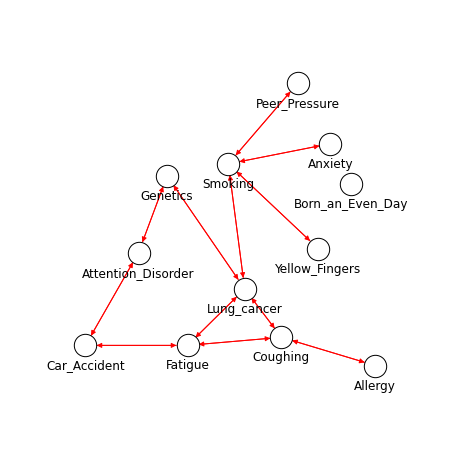

In [8]:
directed = skeleton.to_directed()
draw_graph(directed, pos)

### Шаг 2: Поиск v-структур

Найдем все подмножества вершин, соответствующие определению unshielded triple:

> Тройка вершин (i, j, k) называется **unshielded triple** если i - j - k и i не является смежной с вершиной k.

In [9]:
unshielded_triplets = []

for source_node in directed.nodes:
    middle_nodes = [node for node in skeleton.neighbors(source_node)]
    for middle_node in middle_nodes:
        end_nodes = [node for node in skeleton.neighbors(middle_node) if node != source_node]
        for end_node in end_nodes:
            if end_node not in middle_nodes: # проверяем отсутствие связи между крайними вершинами
                if [end_node, middle_node, source_node] not in unshielded_triplets:
                    unshielded_triplets.append([source_node, middle_node, end_node])

In [10]:
# найденные unshilded triples
print(*unshielded_triplets)

['Smoking', 'Lung_cancer', 'Genetics'] ['Smoking', 'Lung_cancer', 'Fatigue'] ['Smoking', 'Lung_cancer', 'Coughing'] ['Yellow_Fingers', 'Smoking', 'Anxiety'] ['Yellow_Fingers', 'Smoking', 'Peer_Pressure'] ['Yellow_Fingers', 'Smoking', 'Lung_cancer'] ['Anxiety', 'Smoking', 'Peer_Pressure'] ['Anxiety', 'Smoking', 'Lung_cancer'] ['Peer_Pressure', 'Smoking', 'Lung_cancer'] ['Genetics', 'Attention_Disorder', 'Car_Accident'] ['Genetics', 'Lung_cancer', 'Fatigue'] ['Genetics', 'Lung_cancer', 'Coughing'] ['Attention_Disorder', 'Genetics', 'Lung_cancer'] ['Attention_Disorder', 'Car_Accident', 'Fatigue'] ['Car_Accident', 'Fatigue', 'Coughing'] ['Car_Accident', 'Fatigue', 'Lung_cancer'] ['Fatigue', 'Coughing', 'Allergy'] ['Allergy', 'Coughing', 'Lung_cancer']


Теперь мы можем выделить среди 18 найденных unshielded triple те тройки вершин, которые являются v-структурами:

> Тройка вершин (i, j, k) называется **v-структурой** (или **unshielded collider**) если i -> j <- k и i не является смежной с вершиной k.

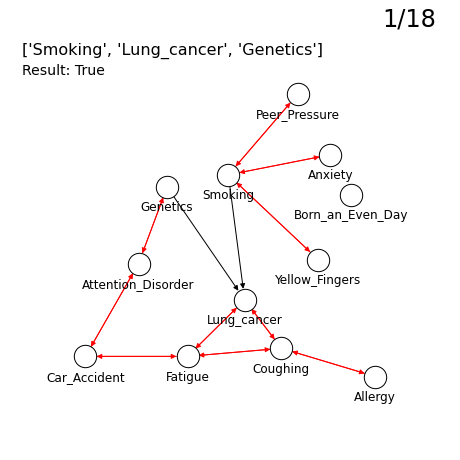

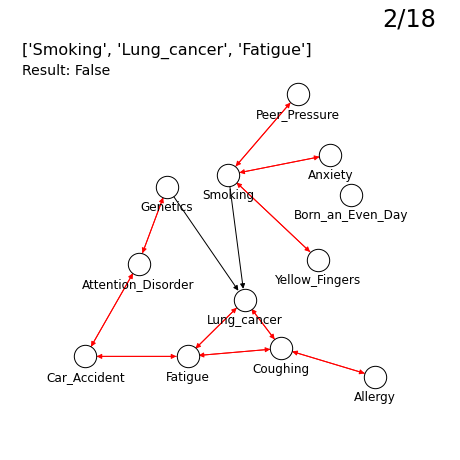

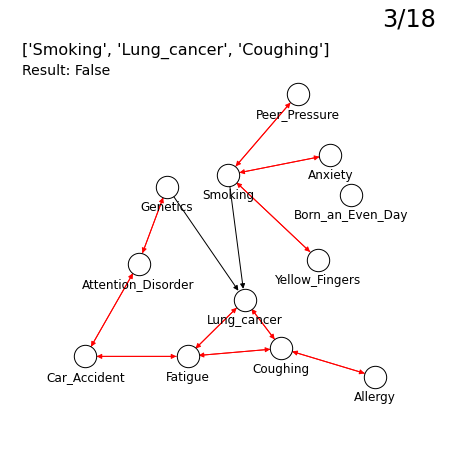

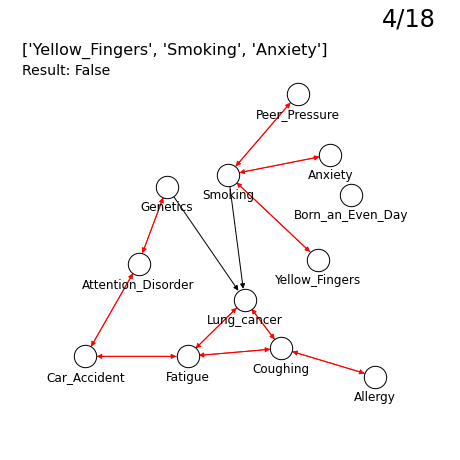

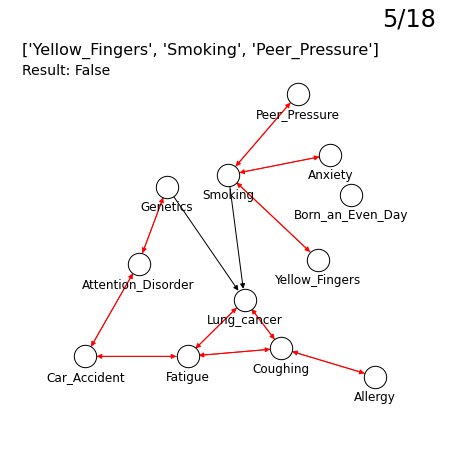

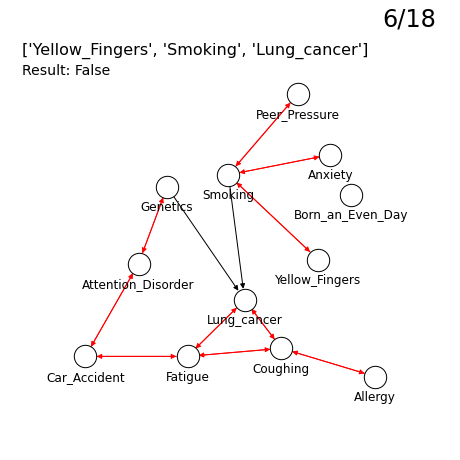

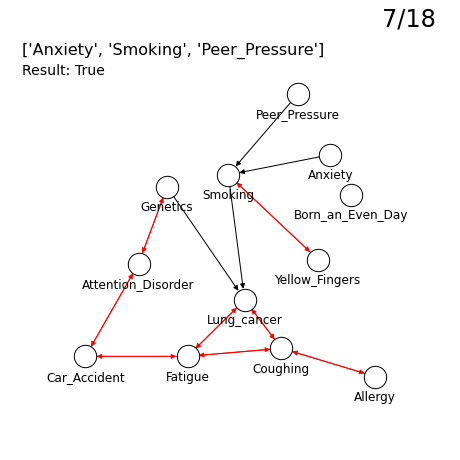

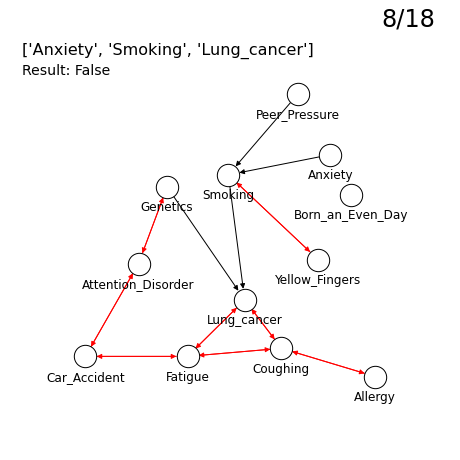

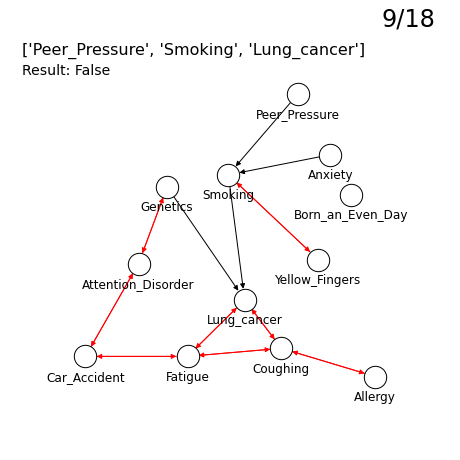

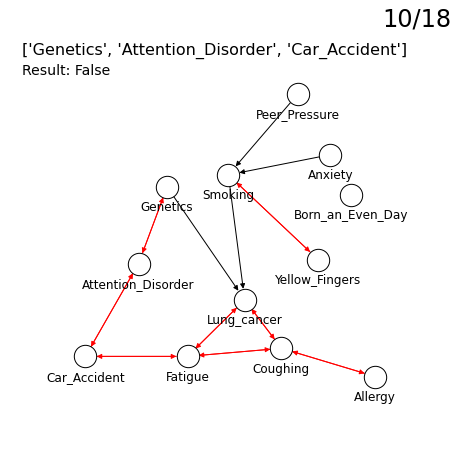

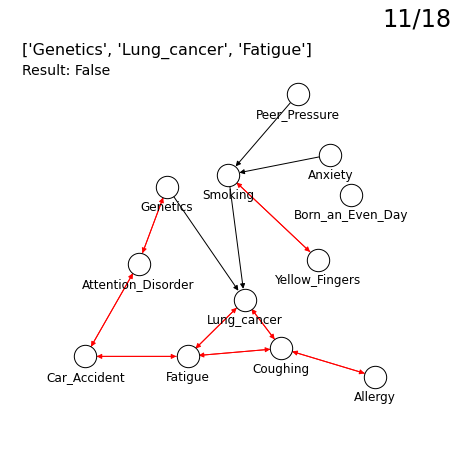

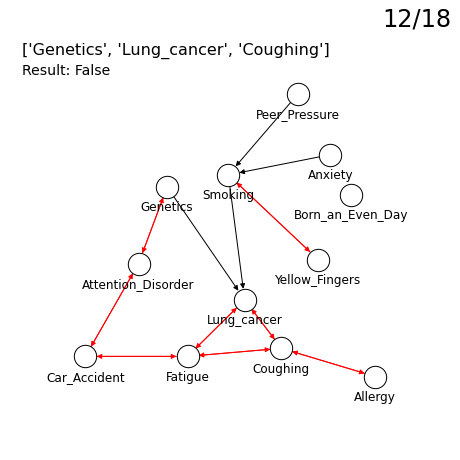

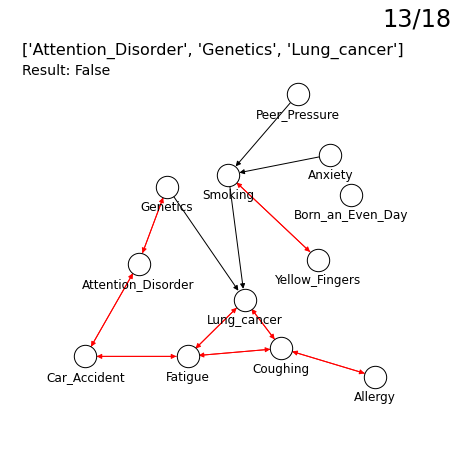

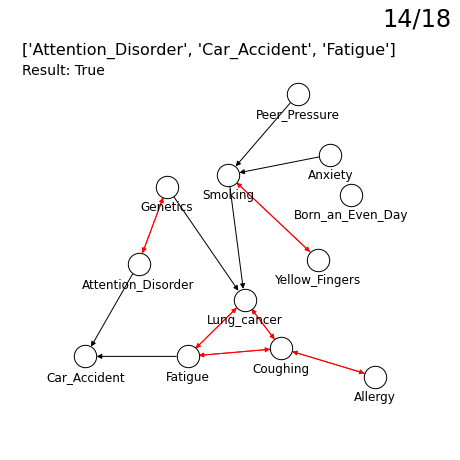

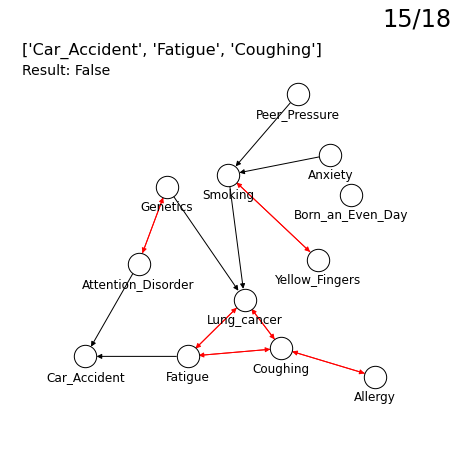

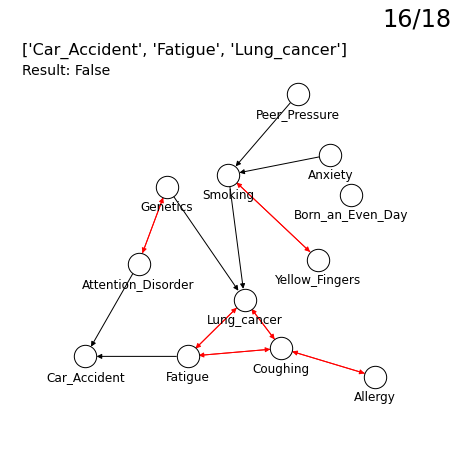

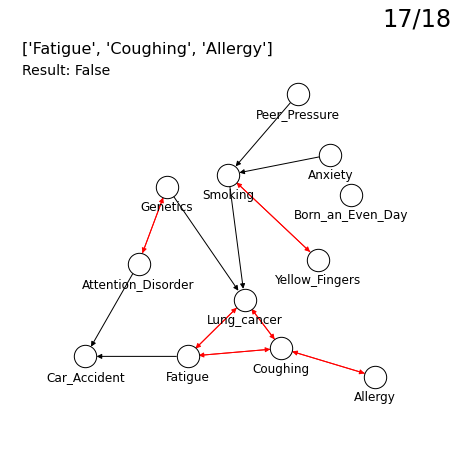

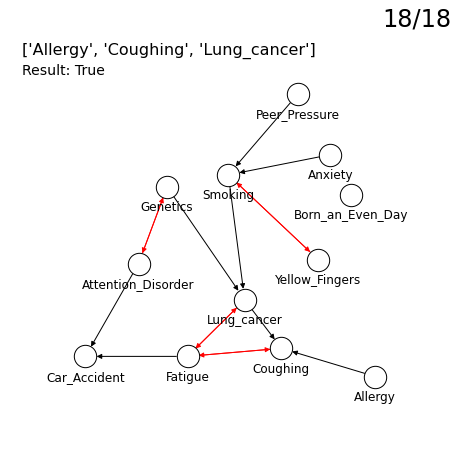

In [11]:
v_structures = []
i = 0

for u_triplet in unshielded_triplets:
    i += 1

    for k in range(len(skeleton.nodes())-2):
        for s in combinations(set(skeleton.nodes()).difference(u_triplet), k):
            s_f = [a for a in s]
            s_f.append(u_triplet[1])
            p_val = pg.partial_corr(data=df, x=u_triplet[0], y=u_triplet[2], covar=list(s_f)).round(3)['p-val'].item()
            if p_val > alpha:
                break
        else:
            continue
        break
    
    if p_val < alpha:
        v_structures.append(u_triplet)
        directed.remove_edges_from([(u_triplet[1], u_triplet[0]), (u_triplet[1], u_triplet[2])])
        
    colors = ['red' if (y,x) in directed.edges() else 'black' for (x,y) in directed.edges()]
    draw_graph(directed, pos)
    plt.text(7.76, 8.7, str(i) + '/' + str(len(unshielded_triplets)), fontsize=24)
    plt.text(-1.05, 8, str(u_triplet), fontsize=16)
    plt.text(-1.05, 7.5, 'Result: ' + str(p_val < alpha), fontsize=14, color='black')

In [12]:
# найденные в данных v-структуры 
print(*v_structures)

['Smoking', 'Lung_cancer', 'Genetics'] ['Anxiety', 'Smoking', 'Peer_Pressure'] ['Attention_Disorder', 'Car_Accident', 'Fatigue'] ['Allergy', 'Coughing', 'Lung_cancer']


### Шаг 3: Применение background knowledge и правил Мика

Вычислив скелет графа и определив v-структуры, мы полчили марковский класс эквивалентности, представленный в форме CPDAG (частично-ориентированный ациклический граф). Дальнейший поиск направления связей подразумевает применение **экспертных знаний** (**background knowledge**) и **ориентационных правил Мика**. 

Экспертные знания обычно отражают ограничения на физически возможные направления стрелок (например, баланс на карте не определяет возраст, но возраст может определять баланс через измеренные / неизмеренные переменные). Для нашего датасета мы имеем два ребра относительно которых представляется возможным зафиксировать стрелку:  ('Yellow_Fingers', 'Smoking') и ('Fatigue', 'Coughing').

В первом случае изменение цвета кожи не влечет за собой уменьшение или увеличение желания курить, поэтому мы можем удалить стрелку 'Yellow_Fingers' -> 'Smoking'.

In [13]:
directed.remove_edges_from([('Yellow_Fingers', 'Smoking')])

Для связи ('Fatigue', 'Coughing') также более характерно появление усталости после кашля, а не наоборот:

In [14]:
directed.remove_edges_from([('Fatigue', 'Coughing')])

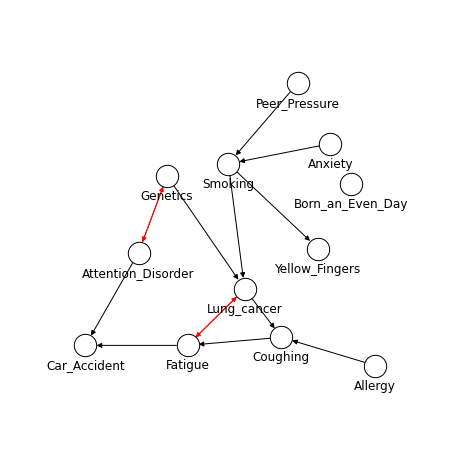

In [15]:
draw_graph(directed, pos)

Из двух последних ребер мы можем определить направление только для ('Lung_cancer', 'Fatigue'): если мы выберем стрелку 'Fatigue' -> 'Lung_cancer', то получим цикл 'Fatigue' -> 'Lung_cancer' -> 'Coughing' -> 'Fatigue'. Это нарушает одно из допущений алгоритма SGS, а следовательно единственно возможный вариант направления связи между этими вершинами это 'Fatigue' <- 'Lung_cancer'.

In [16]:
directed.remove_edges_from([('Fatigue', 'Lung_cancer')])

Направление ребра ('Genetics', 'Attention_Didorder') не удастся установить, так как оба возможных варианта не порождают ни циклов, ни новых v-структур.

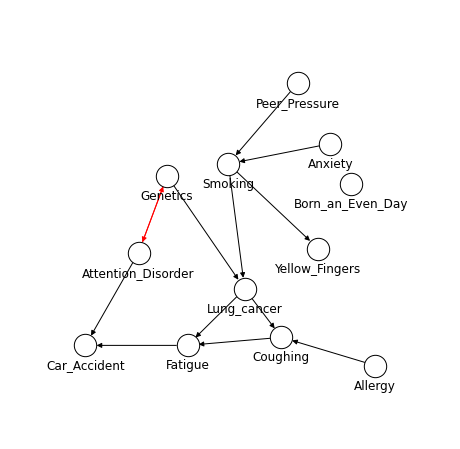

In [17]:
draw_graph(directed, pos)

## Алгоритм Петера-Кларка

Существенная часть causal discovery методов представлена в библиотеке **causal-learn**, к которой мы прямо сейчас перейдем. Закончив с алгоритмом SGS, мы можем опробовать PC - его ключевое отличие это оптимизированный поиск подмножеств вершин в рамках проведения тестов на условную независимость.

In [18]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge

graph_pc_raw = pc(df.values, alpha=alpha, indep_test='fisherz')


  0%|          | 0/12 [00:00<?, ?it/s]

In [19]:
graph_pc_raw.to_nx_graph()

mapping = {node:i for node, i in enumerate(df.columns)}
mapping_r = {i:node for node, i in enumerate(df.columns)}

# добавим корректные названия вершин в граф
graph_pc = nx.relabel_nodes(graph_pc_raw.nx_graph, mapping)

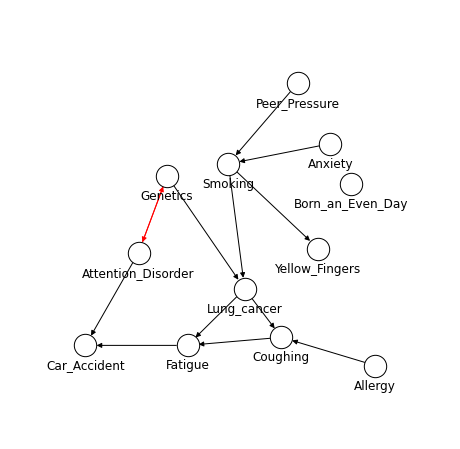

In [20]:
draw_graph(graph_pc, pos)

В библиотеке causal-learn имеется собственный класс для работы с экспертными знаниями:

In [21]:
backgroung_knowledge = BackgroundKnowledge()

Чтобы удалить ребро (в одну или обе стороны), необходимо получить соответствующие ему вершины из объекта GeneralGraph. Например, запретим ребро 'Attention_disorder' -> 'Genetics', а также полностью удалим связь между 'Yellow_Fingers' и 'Smoking':

In [22]:
# достаем вершины из GeneralGraph
nodes = graph_pc_raw.G.get_nodes()

In [23]:
# удаляем возможность построить ребро в одном направлении

node_from = nodes[mapping_r['Attention_Disorder']]
node_to = nodes[mapping_r['Genetics']]

# добавляем запрет на ребро аргумент_1 -> аргумент_2
backgroung_knowledge.add_forbidden_by_node(node_from, node_to)

In [24]:
# полностью удаляем ребро из графа

node_from = nodes[mapping_r['Yellow_Fingers']]
node_to = nodes[mapping_r['Smoking']]

backgroung_knowledge.add_forbidden_by_node(node_from, node_to)
backgroung_knowledge.add_forbidden_by_node(node_to, node_from)

Построим каузальный граф еще раз, но уже с использованием background knowledge:

In [25]:
graph_pc_raw_bk = pc(df.values, alpha=alpha, indep_test='fisherz', background_knowledge=backgroung_knowledge)

  0%|          | 0/12 [00:00<?, ?it/s]

In [26]:
graph_pc_raw_bk.to_nx_graph()

# добавим корректные названия вершин в граф
graph_pc_bk = nx.relabel_nodes(graph_pc_raw_bk.nx_graph, mapping)

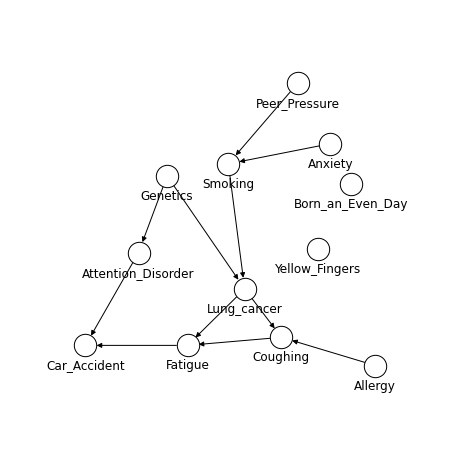

In [27]:
draw_graph(graph_pc_bk, pos)

## **Бонус**: Score-based методы

В качестве дополнительного метода оценки причинно-следственных связей в данных предлагается протестировать алгоритм GES (Greedy Equivalence Search), оценивающий соответствие потенциального каузального графа данным с помощью скоринговой функции (например, BIC).

Алгоритм имеет схожие с PC допущения и включает в себя три шага:
1. Инициализация пустого графа;
2. Последовательное добавление ребер вплоть до достижения локального максимума скоринговой функции (forward phase);
3. Последовательное удаление ребер вплоть до достижения локального максимума скоринговой функции (backward phase).

Полученные промежуточные графы во время шагов 2 и 3 сопоставляются с соответствующими марковскими классами эквивалентности.

In [28]:
from causallearn.search.ScoreBased.GES import ges

graph_ges = ges(df, score_func='local_score_BIC')

In [29]:
import io
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg

pyd = GraphUtils.to_pydot(graph_ges['G'], labels=df.columns)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

FileNotFoundError: [WinError 2] "dot" not found in path.

## Превью к следующим частям семинара

Теперь, когда все направления ребр были идентифицированы, полученный каузальный граф может быть использован для построения оценки эффекта одной переменной на другую. Например, мы можем численно оценить влияние курения на рак легких:

In [30]:
gml = ''.join(nx.generate_gml(graph_pc_bk))
model = CausalModel(
        data = df,
        treatment='Smoking',
        outcome='Lung_cancer',
        graph=gml)

In [31]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                     
──────────(E[Lung_cancer])
d[Smoking]                
Estimand assumption 1, Unconfoundedness: If U→{Smoking} and U→Lung_cancer then P(Lung_cancer|Smoking,,U) = P(Lung_cancer|Smoking,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢            d                          ⎛            d                       
E⎢─────────────────────────(Lung_cancer)⋅⎜─────────────────────────([Smoking])
 ⎣d[Anxiety  Peer_Pressure]              ⎝d[Anxiety  Peer_Pressure]           

 -1⎤
⎞  ⎥
⎟  ⎥
⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Lung_cancer then ¬(U →→{Anxiety,Peer_Pressure})
Estimand assumption 2, Exclusion: If we remove {Anxiety,Peer_Pressure}→{Smoking}, then ¬({Anxiety,Peer_Pressure}→Lung_cancer)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found

In [32]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Оценка эффекта: " + str(estimate.value))

Оценка эффекта: 0.510107299777969
